In [1]:
import math
import numpy as np
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import set_matplotlib_formats, display, Math
import requests
import datetime

# 個人的に好きな図の設定
matplotlib.style.use('classic')
set_matplotlib_formats('svg')

In [2]:
r = requests.get(r'https://www.mhlw.go.jp/content/pcr_positive_daily.csv')
date = []
value = []
for line in r.text.split('\n')[1:]:
    tmp = line.strip().split(',')
    if len(tmp) == 2:
        d = list(map(int, tmp[0].split('/')))
        date.append(datetime.date(*d))
        value.append(int(tmp[1]))
date = np.array(date)
value = np.array(value)

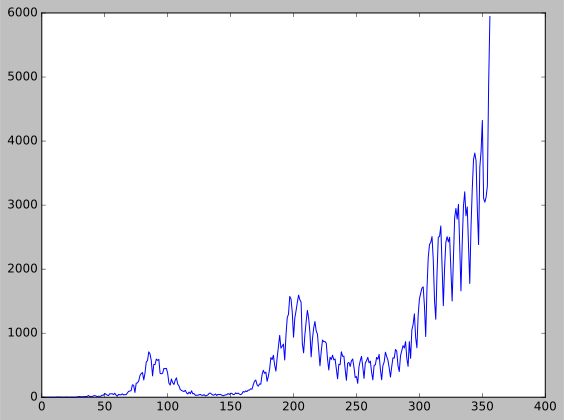

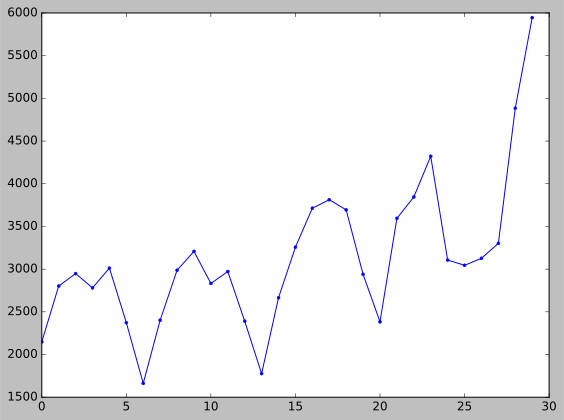

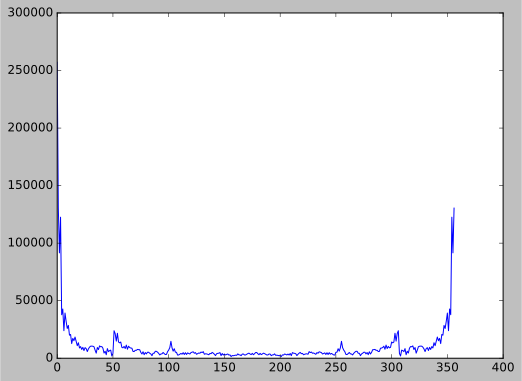

In [3]:
plt.figure(tight_layout=True)
plt.plot(value)
plt.show()
plt.figure(tight_layout=True)
plt.plot(value[-30:], '.-')
plt.show()
plt.figure()
plt.plot(np.abs(np.fft.fft(value)))
plt.show()

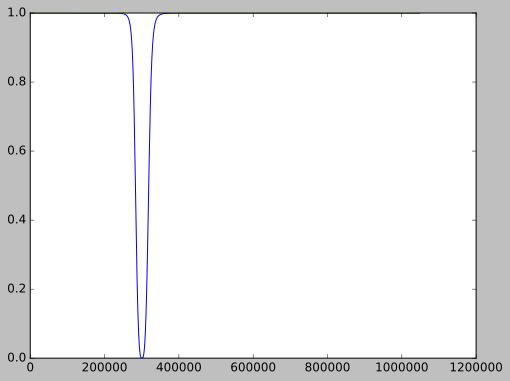

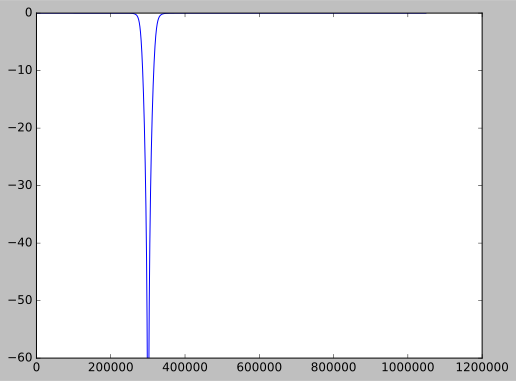

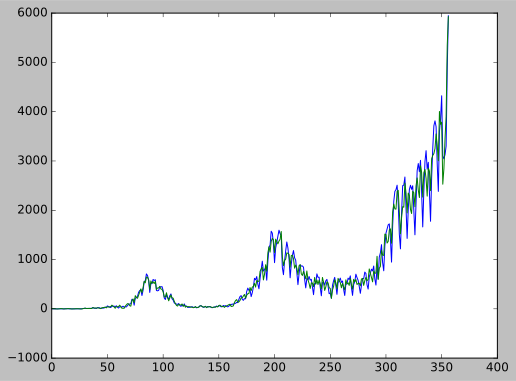

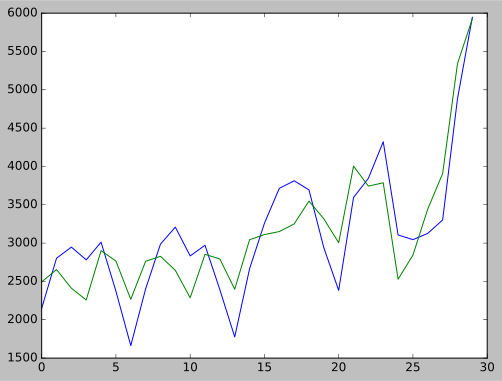

In [4]:
# b = signal.firwin(151, cutoff=[1/7.5, 1/6.5], fs=1, window='hann')
b, a = signal.butter(3, [1/7.5, 1/6.5], btype='bandstop', fs=1)
bf = np.fft.fft(b, 2 ** 21)
af = np.fft.fft(a, 2 ** 21)
plt.figure()
plt.plot(np.abs(bf[:2**20] / af[:2**20]))
plt.show()
plt.figure()
plt.plot(20*np.log10(np.abs(bf[:2**20] / af[:2**20])))
plt.ylim(-60, 0)
plt.show()
plt.plot(value)
plt.plot(signal.filtfilt(b, a, value))
plt.show()
plt.plot(value[-30:])
plt.plot(signal.filtfilt(b, a, value)[-30:])
plt.show()

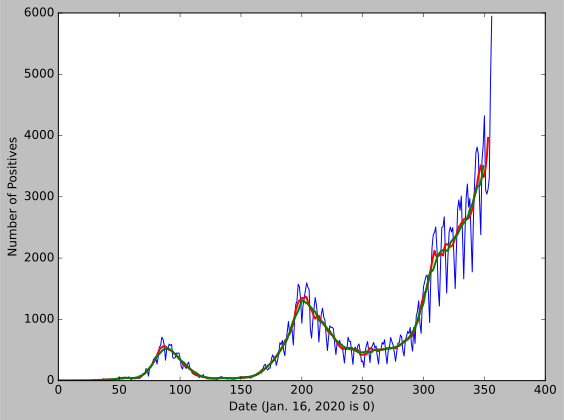

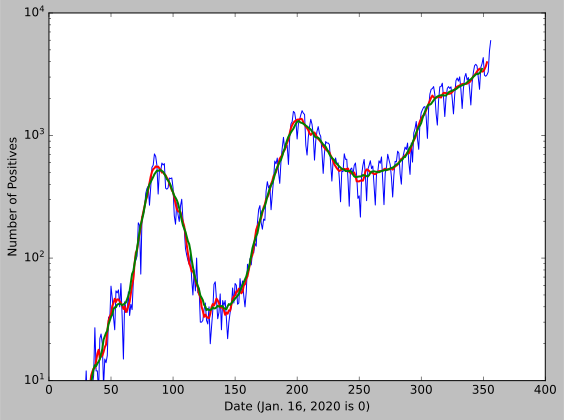

In [5]:
value_smoothed = np.convolve(np.ones(7)/7, value, 'same')[:-3]
value_smoothed2 = np.convolve(np.ones(14)/14, value, 'same')[:-7]
plt.figure(tight_layout=True)
plt.plot(value)
plt.plot(value_smoothed, color='r', linewidth=2)
plt.plot(value_smoothed2, color='g', linewidth=2)
plt.xlabel('Date (Jan. 16, 2020 is 0)')
plt.ylabel('Number of Positives')
plt.show()
plt.figure(tight_layout=True)
plt.plot(value)
plt.semilogy(value_smoothed, color='r', linewidth=2)
plt.semilogy(value_smoothed2, color='g', linewidth=2)
plt.xlabel('Date (Jan. 16, 2020 is 0)')
plt.ylabel('Number of Positives')
plt.ylim(10, 10000)
plt.show()

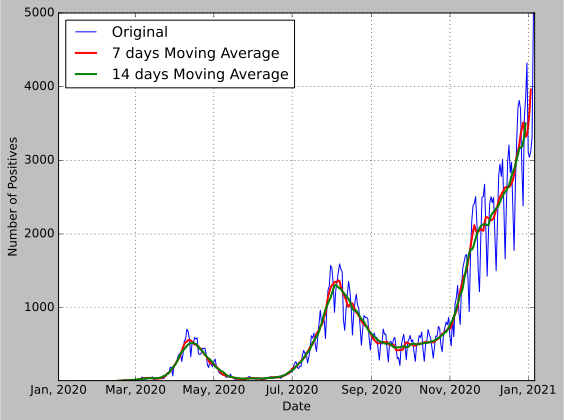

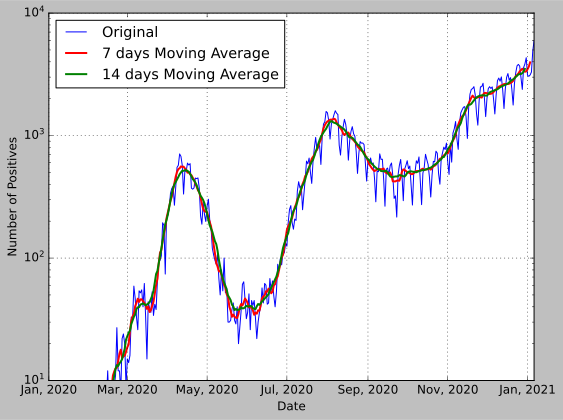

In [6]:
locator = mdates.MonthLocator(bymonth=range(1, 13, 2))
formatter = mdates.DateFormatter('%b, %Y')

date_smoothed = date[:value_smoothed.size]
date_smoothed2 = date[:value_smoothed2.size]

plt.figure(tight_layout=True)
ax = plt.gca()
ax.plot(date, value, label='Original')
ax.plot(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.plot(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 1, 1), None)
ax.set_ylim(10, 5000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(loc='upper left')
ax.grid()
plt.show()

plt.figure(tight_layout=True)
ax = plt.gca()
ax.semilogy(date, value, label='Original')
ax.semilogy(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.semilogy(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 1, 1), None)
ax.set_ylim(10, 10000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(loc='upper left')
ax.grid()
plt.show()

## 最小二乗法

$$\begin{align}
y &= b\exp(ax) \\
\log(y) &= ax + \log(b)
\end{align}$$
最小二乗法を考えると
$$\begin{align}
\begin{bmatrix}
\log(y_1) \\
\vdots \\
\log(y_n)
\end{bmatrix}
&=
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}
\begin{bmatrix}
a \\
\log(b)
\end{bmatrix}
\end{align}$$

$$
\begin{align}
\begin{bmatrix}
a \\
\log(b)
\end{bmatrix}
&=
\left(\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}^T
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}\right)^{-1}
\begin{bmatrix}
x_1 & 1 \\
\vdots & \vdots \\
x_n & 1
\end{bmatrix}^T
\begin{bmatrix}
\log(y_1) \\
\vdots \\
\log(y_n)
\end{bmatrix}
\end{align}$$

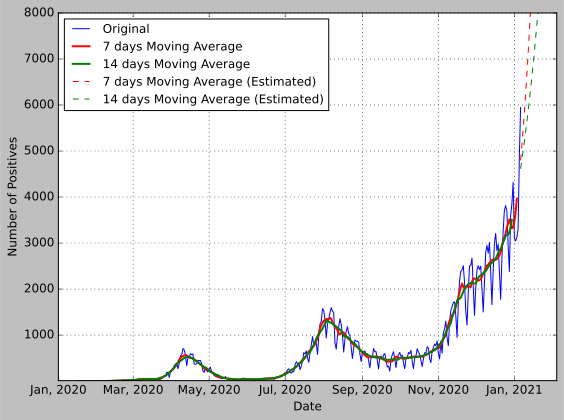

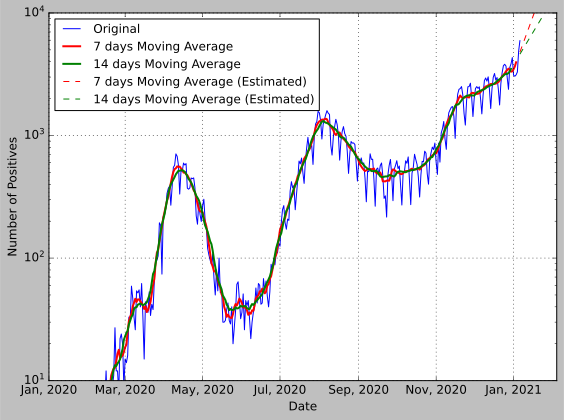

In [7]:
def date2num(x):
    f = np.frompyfunc(lambda x: x.toordinal(), 1, 1)
    return f(x)


def num2date(x):
    f = np.frompyfunc(lambda x: datetime.date.fromordinal(x), 1, 1)
    return f(x)


def lsm(x, y):
    A = np.vstack([x - x.min(), np.ones(x.size)]).astype(np.float64).T
    y = np.log(y)
    b = np.linalg.pinv(A) @ y
    return b[0], np.exp(b[1]), x.min()


def exp_delay(x, a, b, c):
    return b * np.exp(a * (x - c))


a, b, c = lsm(date2num(date_smoothed[-3:]), value_smoothed[-3:])
a2, b2, c2 = lsm(date2num(date_smoothed2[-3:]), value_smoothed2[-3:])

date_plot = np.arange(30) + date[-1].toordinal()

now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')

plt.figure(tight_layout=True)
ax = plt.gca()
ax.plot(date, value, label='Original')
ax.plot(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.plot(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.plot(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.plot(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 1, 1), None)
ax.set_ylim(10, 20000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_plot_{}.png'.format(now))
plt.savefig('figs/positives_plot_{}.svg'.format(now))
plt.show()

plt.figure(tight_layout=True)
ax = plt.gca()
ax.semilogy(date, value, label='Original')
ax.semilogy(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.semilogy(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 1, 1), None)
ax.set_ylim(10, 20000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_semilogy_{}.png'.format(now))
plt.savefig('figs/positives_semilogy_{}.svg'.format(now))
plt.show()

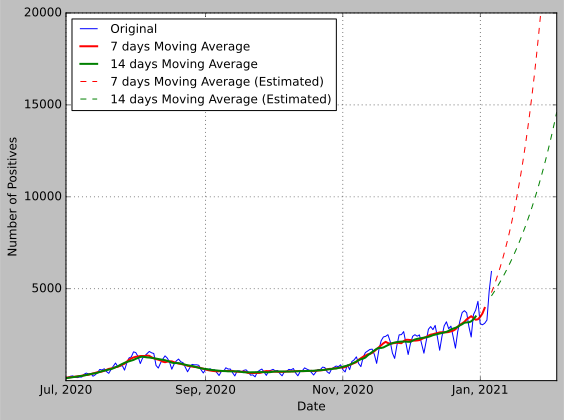

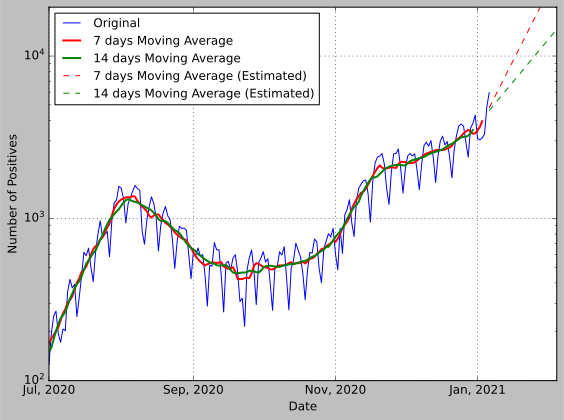

In [10]:
plt.figure(tight_layout=True)
ax = plt.gca()
ax.plot(date, value, label='Original')
ax.plot(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.plot(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.plot(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.plot(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 7, 1), None)
ax.set_ylim(10, 20000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_plot_detail_{}.png'.format(now))
plt.savefig('figs/positives_plot_detail_{}.svg'.format(now))
plt.show()

plt.figure(tight_layout=True)
ax = plt.gca()
ax.semilogy(date, value, label='Original')
ax.semilogy(date_smoothed, value_smoothed, color='r', linewidth=2, label='7 days Moving Average')
ax.semilogy(date_smoothed2, value_smoothed2, color='g', linewidth=2, label='14 days Moving Average')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a, b, c), 'r--', label='7 days Moving Average (Estimated)')
ax.semilogy(num2date(date_plot), exp_delay(date_plot, a2, b2, c2), 'g--', label='14 days Moving Average (Estimated)')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Positives')
ax.set_xlim(datetime.date(2020, 7, 1), None)
ax.set_ylim(100, 20000)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.legend(fontsize=12, loc='upper left')
ax.grid()
plt.savefig('figs/positives_semilogy_detail_{}.png'.format(now))
plt.savefig('figs/positives_semilogy_detail_{}.svg'.format(now))
plt.show()